# The basics.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

plotpar = {'axes.labelsize': 30,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Let's use the Sun as a test case.

In [4]:
bprp = 0.82
prot = 26
prot_err = .01
log10_age = np.log10(4.56*1e9)

We'll plot the gyrochronology model over a range of ages. 

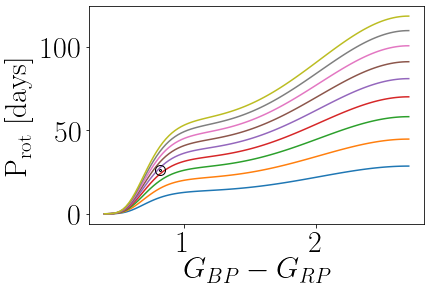

In [23]:
import stardate2 as sd

logages = np.log10(np.arange(1, 10)*1e9)
bprps = np.linspace(.4, 2.7, 100)

for a in logages:
    plt.plot(bprps, sd.angus_2019_model(a, bprps))

plt.plot(bprp, prot, "o", color="none", mec="k", ms=10)
plt.plot(bprp, prot, ".", color="none", mec="k", ms=4)

plt.xlabel("$G_{BP} - G_{RP}$");
plt.ylabel("$\mathrm{P_{rot}~[days]}$");

Now let's figure out what age this model would predict for the Sun. We can evaluate the posterior probability function like this:

In [25]:
print(sd.lnprob(log10_age, prot, prot_err, bprp))

-1.73633807261376


In [34]:
import emcee

ndim, nwalkers = 1, 25
p0 = np.random.randn(nwalkers, ndim)*1e-2 + 9

sampler = emcee.EnsembleSampler(nwalkers, ndim, sd.lnprob, args=[prot, prot_err, bprp])
state = sampler.run_mcmc(p0, 1000);
sampler.reset()
sampler.run_mcmc(state, 10000);

Let's plot the posterior over age. 

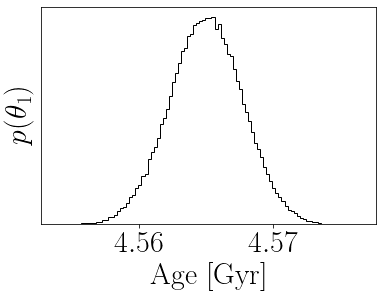

In [46]:
samples = sampler.get_chain(flat=True)

plt.hist((10**samples)*1e-9, 100, color="k", histtype="step")
plt.xlabel(r"$\mathrm{Age~[Gyr]}$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

So that's how to calculate a Bayesian gyrochronology age for star if you have it's rotation period and Gaia-color.

In [50]:
import pickle
import exoplanet as xo

with open("gp_model.pkl", "rb") as f:
    model, map_soln = pickle.load(f)

with model:
    func = xo.get_theano_function_for_var(model.y_test)
    args = xo.utils.get_args_for_theano_function(map_soln)
    ind1 = model.vars.index(model.x1_test)
    ind2 = model.vars.index(model.x2_test)
    
def pred_at(teff, age):
    args[ind1][0] = teff
    args[ind2][0] = age
    return func(*args)

AttributeError: 'Model' object has no attribute 'y_test'